## ツリー系

In [68]:
import pandas as pd
import numpy as np

import pickle
import json
import xgboost as xgb

import matplotlib.pyplot as plt
import japanize_matplotlib

In [56]:
test_df = pd.read_csv('../output/中間データ/評価用データ/test_preprocessed.csv')
test_df.head()

,time,total_load_actual,gene_sum,sus_rate,fossil_rate,gene_load_ratio,gene_cost,residual_demand,residual_demand_ratio,w_gene_cost,...,weighted_temp,weighted_pressure,weighted_humidity,weighted_clouds_all,encoded_price_weekday_hour,valencia_weather_main_LabelEn,madrid_weather_main_LabelEn,bilbao_weather_main_LabelEn,barcelona_weather_main_LabelEn,seville_weather_main_LabelEn
0,2017-12-31 23:00:00+00:00,24257.0,23420.0,0.459137,0.213962,0.965494,1291665.0,13504.0,0.556705,55.152220,...,283.924904,1024.633059,70.660494,2.277092,58.414167,2,1,2,1,1
1,2018-01-01 00:00:00+00:00,22207.0,23489.0,0.417259,0.212993,1.057730,1233525.0,12406.0,0.558653,52.515007,...,283.240165,1024.772291,61.603567,0.521262,50.789231,1,1,2,1,1
2,2018-01-01 01:00:00+00:00,20799.0,24116.0,0.400315,0.201360,1.159479,1214025.0,11145.0,0.535843,50.341060,...,283.257579,1025.224966,62.687243,0.000000,47.007692,1,1,1,1,1
3,2018-01-01 02:00:00+00:00,19921.0,24816.0,0.391401,0.190482,1.245721,1203920.0,10208.0,0.512424,48.513862,...,282.476523,1025.641975,77.792867,0.000000,44.716154,1,1,3,1,1
4,2018-01-01 03:00:00+00:00,19555.0,24552.0,0.405059,0.183040,1.255536,1197970.0,9610.0,0.491434,48.793174,...,281.531255,1026.094650,70.982167,7.818930,43.612308,1,1,3,2,1


In [57]:
X_test = test_df.drop(columns=['time'])
X_test['weight'] = 1

In [58]:
with open('../output/モデル/lgb_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
model = loaded_model['model']

y_pred_lgb = model.predict(X_test)

In [59]:
# # モデル読み込み
# with open('../output/モデル/xgb_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# model = loaded_model['model']  # xgb.Booster型を想定

# # X_test を DMatrix に変換
# dtest = xgb.DMatrix(X_test)

# # 予測実行
# y_pred_xgb = model.predict(dtest)

In [60]:
# y_pred_ens = np.mean([y_pred_lgb, y_pred_xgb], axis=0)

#### 予測結果の出力

In [61]:
result_df = pd.read_csv('../input/提出用データ/sample_submit.csv', header=None)

/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_6585/3625653417.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  result_df.iloc[:, 0] = pd.to_datetime(result_df.iloc[:, 0])


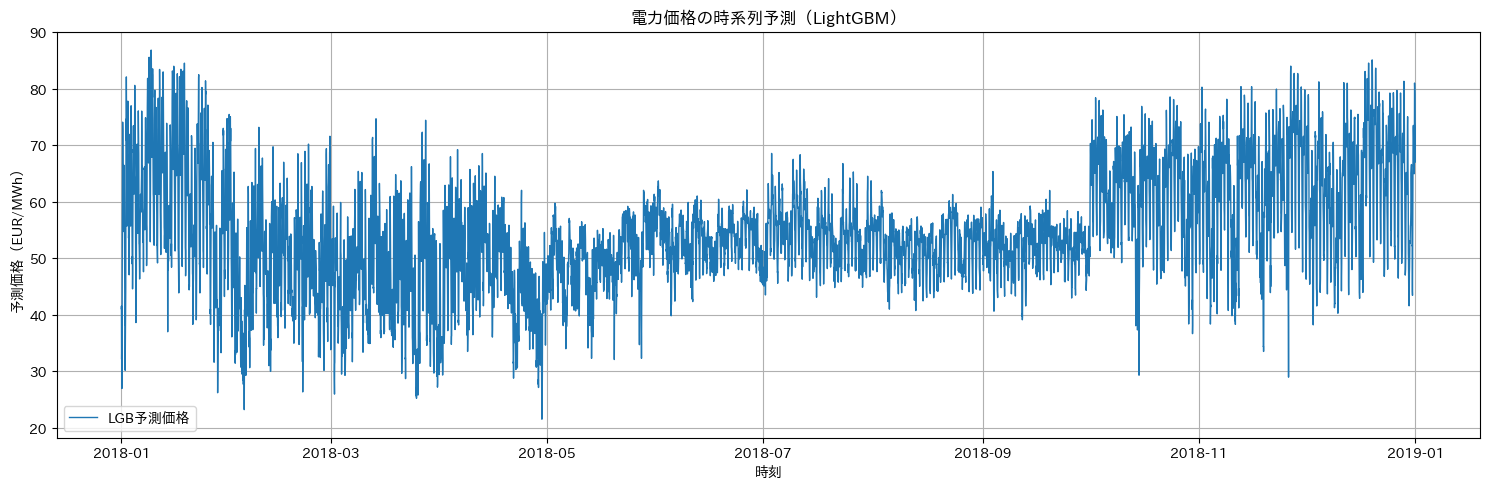

In [69]:
result_df.iloc[:, 1] = y_pred_lgb
result_df.to_csv('../output/予測結果/予測結果_lgb.csv', index=False)
result_df.head()

# time列をdatetime型に変換
result_df.iloc[:, 0] = pd.to_datetime(result_df.iloc[:, 0])

# プロット
plt.figure(figsize=(15, 5))
plt.plot(result_df.iloc[:, 0], result_df.iloc[:, 1], label='LGB予測価格', linewidth=1)

plt.xlabel('時刻')
plt.ylabel('予測価格（EUR/MWh）')
plt.title('電力価格の時系列予測（LightGBM）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
# result_df.iloc[:, 1] = y_pred_xgb
# result_df.to_csv('../output/予測結果/予測結果_xgb.csv', index=False)
# result_df.head()

In [64]:
# result_df.iloc[:, 1] = y_pred_ens
# result_df.to_csv('../output/予測結果/予測結果_ens.csv', index=False)
# result_df.head()

## LSTM

#### 24時間前

In [65]:
test_features_for_lstm24_df = pd.read_csv('../output/中間データ/評価用データ/test_features_for_lstm24.csv')

In [66]:
from tensorflow.keras.models import load_model

# モデル本体
lesm_model24 = load_model('../output/モデル/lstm_model24.keras')

In [67]:
SEQ_LEN = 24

X_test = []
for i in range(len(test_features_for_lstm24_df) - SEQ_LEN):
    X_test.append(test_features_for_lstm24_df[i:i+SEQ_LEN])
X_test = np.array(X_test)
y_pred_lstm24 = lesm_model24.predict(X_test).flatten()

ValueError: Input 0 of layer "functional_45" is incompatible with the layer: expected shape=(None, 24, 55), found shape=(32, 24, 52)

In [ ]:
result_df.iloc[:, 1] = y_pred_lstm24
result_df.to_csv('../output/予測結果/予測結果_lstm24.csv', index=False)
result_df.head()

,0,1
0,2018-01-01 00:00:00+01:00,34.899136
1,2018-01-01 01:00:00+01:00,35.501614
2,2018-01-01 02:00:00+01:00,31.696690
3,2018-01-01 03:00:00+01:00,27.906910
4,2018-01-01 04:00:00+01:00,27.841883


#### 1週間

In [ ]:
test_features_for_lstm168_df = pd.read_csv('../output/中間データ/評価用データ/test_features_for_lstm168.csv')

# モデル本体
lesm_model168 = load_model('../output/モデル/lstm_model168.keras')

SEQ_LEN = 168

X_test = []
for i in range(len(test_features_for_lstm168_df) - SEQ_LEN):
    X_test.append(test_features_for_lstm168_df[i:i+SEQ_LEN])
X_test = np.array(X_test)
y_pred_lstm168 = lesm_model168.predict(X_test).flatten()

274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


In [ ]:
y_pred_ens = np.mean([y_pred_lgb, y_pred_lstm24], axis=0)

In [ ]:
result_df.iloc[:, 1] = y_pred_ens
result_df.to_csv('../output/予測結果/予測結果_ens.csv', index=False)
result_df.head()

,0,1
0,2018-01-01 00:00:00+01:00,36.133328
1,2018-01-01 01:00:00+01:00,33.510258
2,2018-01-01 02:00:00+01:00,29.593344
3,2018-01-01 03:00:00+01:00,27.681537
4,2018-01-01 04:00:00+01:00,26.330203
